In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [24]:
sarcasm_df = pd.read_csv("data/train-balanced-sarcasm.csv")


In [3]:
sarcasm_df.head()


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


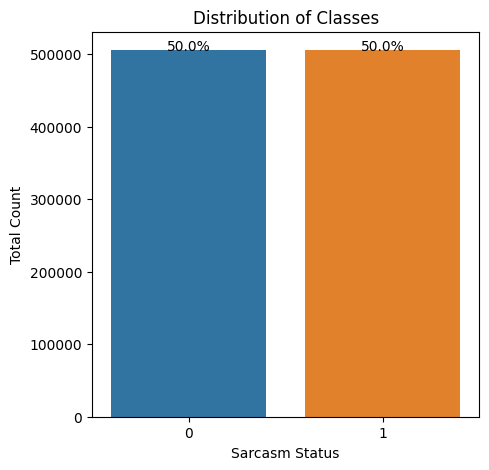

In [5]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x="label", data=sarcasm_df)
ax.set(title="Distribution of Classes", xlabel="Sarcasm Status", ylabel="Total Count")
total = float(len(sarcasm_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:1.1f}%".format((height / total) * 100),
        ha="center",
    )
plt.show()


In [6]:
sarcasm_df["subreddit"].value_counts()[:5]


subreddit
AskReddit          65677
politics           39496
worldnews          26377
leagueoflegends    21037
pcmasterrace       18988
Name: count, dtype: int64

In [25]:
top_reddits = ["AskReddit", "politics", "worldnews", "leagueoflegends", "pcmasterrace"]

subreddit_df = pd.DataFrame()
subreddit_df["subreddit"] = top_reddits
subreddit_df["sarcastic"] = np.nan
subreddit_df["natural"] = np.nan
subreddit_df["total"] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[
        sarcasm_df["subreddit"] == subreddit_df.subreddit.iloc[i]
    ].copy()
    length = len(temp)
    count_sarcastic = len(temp.loc[temp["label"] == 1])
    subreddit_df.loc[i, "sarcastic"] = count_sarcastic
    subreddit_df.loc[i, "natural"] = length - count_sarcastic
    subreddit_df.loc[i, "total"] = length


In [8]:
subreddit_df


,subreddit,sarcastic,natural,total
0,AskReddit,26367.0,39310.0,65677.0
1,politics,23910.0,15586.0,39496.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8228.0,18988.0


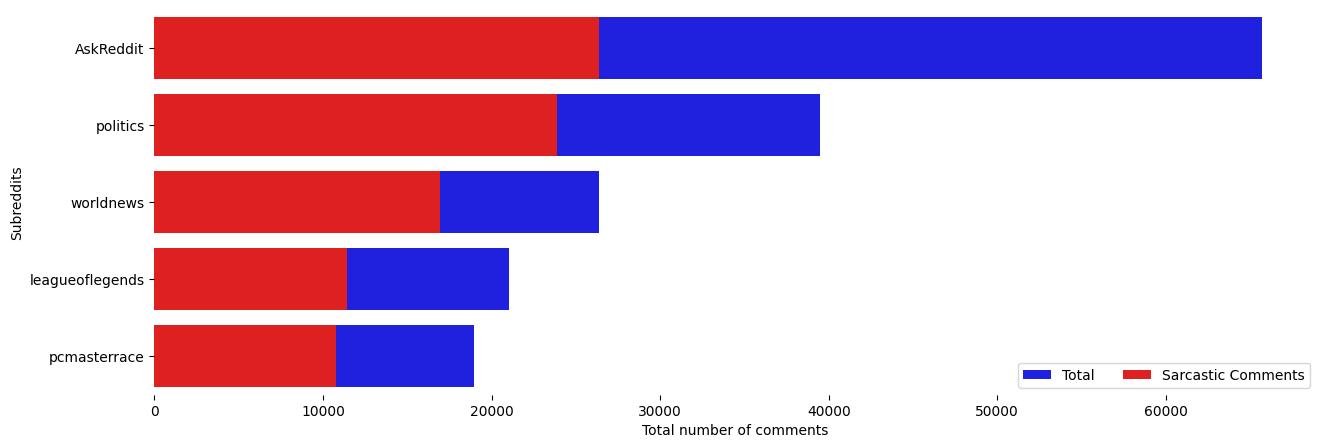

In [9]:
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit_df, label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(
    x="sarcastic",
    y="subreddit",
    data=subreddit_df,
    label="Sarcastic Comments",
    color="r",
)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Subreddits", xlabel="Total number of comments")
sns.despine(left=True, bottom=True)


In [10]:
# Preprocessing


In [26]:
# We just need comment & label columns
# So, let's remove others.
sarcasm_df.drop(
    [
        "author",
        "subreddit",
        "score",
        "ups",
        "downs",
        "date",
        "created_utc",
        "parent_comment",
    ],
    axis=1,
    inplace=True,
)
# remove empty rows
sarcasm_df.dropna(inplace=True)
sarcasm_df.head()


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [13]:
# Here we inspect data for missing values
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1010771 non-null  int64 
 1   comment  1010771 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [27]:
# Some comments are missing, so we drop the corresponding rows.
sarcasm_df.dropna(subset=["comment"], inplace=True)
# also convert to lower case and remove punctuation
sarcasm_df["comment"] = sarcasm_df["comment"].str.lower()
sarcasm_df["comment"] = sarcasm_df["comment"].str.replace("[^\w\s]", "")


In [14]:
# Now we compare the number of instances for each class (1 - sarcasm, 0 - not). We can see, that the dataset is balanced and classes have almost the same size
sarcasm_df["label"].value_counts()


label
0    505403
1    505368
Name: count, dtype: int64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    sarcasm_df["comment"], sarcasm_df["label"], test_size=0.3, random_state=42
)


In [32]:
# create tf-idf encoder
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# encode training data
train_features = tf_idf.fit_transform(x_train)
# encode test data
test_features = tf_idf.transform(x_test)

# logistic regression model with tf-idf encoder
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(train_features, y_train)
pred_labels_log_reg = log_reg.predict(test_features)
print("Logistic regression accuracy: ", accuracy_score(y_test, pred_labels_log_reg))


Logistic regression accuracy:  0.7189511661038412
